*All of the code in this notebook is done to maxmise clarity.  
For more beautiful and optimised code, please check the implemenetation of the classes and analysing functions.*

# Initialisation
Import the necessary class and define the constants for the Oslo Model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pile import Pile

# Constants
POSSIBLE_THRESHOLD_SLOPES = (1, 2)
OSLO_PROBS = (0.5, 0.5)

# Task 1
## Threshold Slopes Test
Create some length 16 piles with different values of $p$:

In [2]:
probs1 = (1, 0)  # p = 1
probs2 = (0, 1)  # p = 0

pile1 = Pile(16, probs1, POSSIBLE_THRESHOLD_SLOPES, name="BTW pile, length 16")
pile2 = Pile(16, probs2, POSSIBLE_THRESHOLD_SLOPES)

oslo_pile_xs = Pile(16, OSLO_PROBS, POSSIBLE_THRESHOLD_SLOPES, name="Oslo pile, length 16")

All threshold slopes of *pile1* should be 1:

In [3]:
pile1.get_threshold_slopes()

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

All threshold slopes of *pile2* should be 2:

In [4]:
pile2.get_threshold_slopes()

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

Around half of the threshold slopes in *oslo_pile_xs* should be 1, and the other half should be 2:

In [5]:
oslo_pile_xs.get_threshold_slopes()

[1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1]

## BTW vs. Oslo Test
Note that *pile1* with $p = 1$ is the BTW model. We can recover its 1D recurrent configuration (staircase) by dropping enough grains on to the pile:

In [6]:
for _ in range(500):
    pile1.drop_grain()
    
pile1.get_heights()

[16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

At the stable state, dropping a grain to the *i*th site of the pile will result in an avalanche size of $s = L - i$, where $s$ is the avalanche size, $L$ the length of the pile.

In [7]:
# i = 0
pile1.drop_grain()
pile1.ava_size

16

In [8]:
# i = 6
pile1.drop_grain(site_index=6)
pile1.ava_size

10

Now we try the same thing with the Oslo pile:

In [9]:
for _ in range(500):
    oslo_pile_xs.drop_grain()
    
oslo_pile_xs.get_heights()

[29, 27, 25, 24, 23, 21, 19, 17, 15, 13, 11, 10, 8, 6, 4, 2]

Finally, we compare the pile heights of the two piles versus time (number of grains dropped):

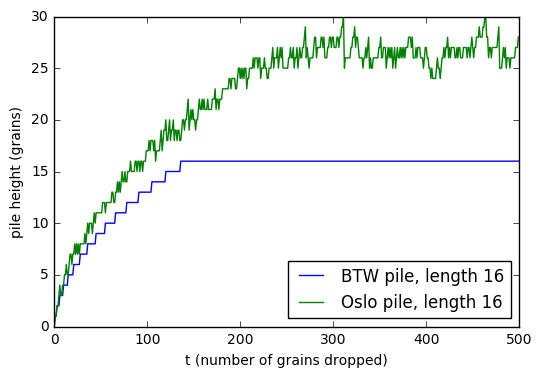

In [10]:
# reinitialise the piles
pile1.reset()
oslo_pile_xs.reset()

for i in (pile1, oslo_pile_xs):
    pile_heights = []
    
    # drop 500 grains
    for t in range(500):
        pile_heights.append(i.get_pile_height())
        i.drop_grain()
    plt.plot(pile_heights, label=i.name)
    
plt.xlabel("t (number of grains dropped)")
plt.ylabel("pile height (grains)")
plt.legend(loc=0)
plt.show()

Arriving the recurring configurations, we can keep dropping grains to the *oslo_pile_xs* and the pile height should average to $\langle h \rangle=26.5$.

In [11]:
pile_heights = []

for i in range(10000):
    oslo_pile_xs.drop_grain()
    pile_heights.append(oslo_pile_xs.get_pile_height())
    
np.average(pile_heights)

26.524799999999999

As we can see, the Oslo model exhibits very different behaviours to the BTW model.  
These tests have also sufficiently proved the correctness of the program.

---

# Task 2a

## Save/load Data
We first save the simulation data to a file, as simulating large system requires a lot of computational time.
The pile reaches a steady state when the last site topples. We can use this property to determine the amount of grains to drop.

~~~python

oslo_pile_xs = Pile(16, OSLO_PROBS, POSSIBLE_THRESHOLD_SLOPES)
oslo_pile_s = Pile(32, OSLO_PROBS, POSSIBLE_THRESHOLD_SLOPES)
oslo_pile_m = Pile(64, OSLO_PROBS, POSSIBLE_THRESHOLD_SLOPES)
oslo_pile_l = Pile(128, OSLO_PROBS, POSSIBLE_THRESHOLD_SLOPES)
oslo_pile_xl = Pile(256, OSLO_PROBS, POSSIBLE_THRESHOLD_SLOPES)
oslo_pile_xxl = Pile(512, OSLO_PROBS, POSSIBLE_THRESHOLD_SLOPES)

piles = (oslo_pile_xs, oslo_pile_s, oslo_pile_m, oslo_pile_l, oslo_pile_xl, oslo_pile_xxl)
data_dict = {}

for pile in piles:
    pile_dict = {'heights': [], 'avalanche size': []}
    
    while not pile.is_at_steady_state:
        pile_dict['heights'].append(pile.get_pile_height())
        pile_dict['avalanche size'].append(pile.ava_size)
        pile.drop_grain()

    for _ in range(10000):
        pile_dict['heights'].append(pile.get_pile_height())
        pile_dict['avalanche size'].append(pile.ava_size)
        pile.drop_grain()

    data_dict[pile.length] = pile_dict

pickle.dump(data_dict, open('height_and_avalanche_data', 'wb'))
    
~~~

When the pile reaches a steady state, we drop 10,000 more grains for the average height calculation later.  
The above code block takes around 30 minutes to run.

**4.8259100914001465  
9.402869939804077  
20.45176386833191  
60.15304374694824  
272.26051449775696  
1928.6817326545715**

We can load the data back into program:

In [19]:
data_dict = pickle.load(open('height_and_avalanche_data', 'rb'))

## Height vs. Time Plots
**Plot the pile height against time (number of grains dropped):**

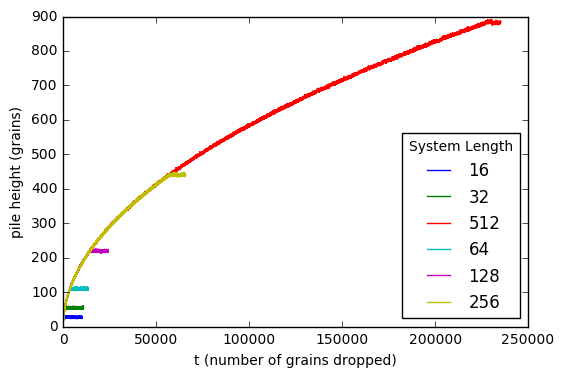

In [20]:
for length, pile_dict in data_dict.items():
    plt.figure(1)
    plt.plot(pile_dict['heights'], label=length)

plt.xlabel("t (number of grains dropped)")
plt.ylabel("pile height (grains)")
plt.legend(loc=0, title="System Length")
plt.show()

**As we can see, the height of the piles initially follows a curve. This is when the pile is still in transient configurations. At certain times, the heights flatten, denoting the corresponding piles reaching recurrent configurations.** 

## fit the line with smoothed points